<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# **Procesamiento del Lenguaje Natural - Desafío 2**
---
##*Facultad de Ingeniería de la Universidad de Buenos Aires*
##*Laboratorio de Sistemas Embebidos*                                  
##*David Canal*
---
##**Consigna de trabajo**
---
* Crear sus propios vectores con Gensim basado en lo visto en clase con otro dataset.

* Probar términos de interés y explicar similitudes en el espacio de embeddings (sacar conclusiones entre palabras similitudes y diferencias).

* Graficarlos.

* Obtener conclusiones.


##**Resolución**
---

In [1]:
%pip install gensim tensorflow seaborn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 39.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np


## 1. Selección y preparación del dataset

### **Dataset elegido: Britney Spears**

Se seleccionó el dataset de Britney Spears por las siguientes razones (además de que soy fan de la artista):

- Riqueza semántica: las canciones pop contienen vocabulario emocional y conceptual diverso.
- Consistencia de estilo: un solo artista permite analizar patrones semánticos específicos.
- Temática característica: Palabras relacionadas con amor, baile, música, entre otros.
- Volumen adecuado: Suficiente texto para entrenar embeddings de calidad.

### **Descarga y preparación del dataset**


In [3]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")


--2025-10-19 21:56:01--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2025-10-19 21:56:01--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-10-19 21:56:01--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

In [4]:
# Verificar bandas disponibles
os.listdir("./songs_dataset/")

['disney.txt',
 'alicia-keys.txt',
 'al-green.txt',
 'nirvana.txt',
 'eminem.txt',
 'dickinson.txt',
 'kanye.txt',
 'michael-jackson.txt',
 'kanye-west.txt',
 'dj-khaled.txt',
 'lin-manuel-miranda.txt',
 'Lil_Wayne.txt',
 'beatles.txt',
 'notorious-big.txt',
 'blink-182.txt',
 'drake.txt',
 'lady-gaga.txt',
 'britney-spears.txt',
 'janisjoplin.txt',
 'adele.txt',
 'lil-wayne.txt',
 'bruno-mars.txt',
 'amy-winehouse.txt',
 'joni-mitchell.txt',
 'missy-elliott.txt',
 'radiohead.txt',
 'rihanna.txt',
 'leonard-cohen.txt',
 'prince.txt',
 'dolly-parton.txt',
 'bob-dylan.txt',
 'patti-smith.txt',
 'Kanye_West.txt',
 'nursery_rhymes.txt',
 'nickelback.txt',
 'bieber.txt',
 'dr-seuss.txt',
 'paul-simon.txt',
 'cake.txt',
 'r-kelly.txt',
 'lorde.txt',
 'bruce-springsteen.txt',
 'notorious_big.txt',
 'bob-marley.txt',
 'ludacris.txt',
 'johnny-cash.txt',
 'nicki-minaj.txt',
 'bjork.txt',
 'jimi-hendrix.txt']

### **Carga del dataset de Britney Spears**

Se carga el archivo con la canción de Britney Spears, utilizando saltos de línea para separar las oraciones. Esto permite que cada línea de la canción sea tratada como un documento independiente para el entrenamiento de Word2Vec.


In [5]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/britney-spears.txt', sep='/n', header=None)
df.head()


/tmp/ipython-input-2544343471.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/britney-spears.txt', sep='/n', header=None)


,0
0,They say get ready for the revolution
1,I think it's time we find some sorta solution
2,Somebody's caught up in the endless pollution
3,"They need to wake up, stop living illusions I ..."
4,Why won't somebody feel this


### **Estadísticas del dataset**

El dataset de Britney Spears contiene **3,848 documentos** (líneas de canciones), lo que proporciona un corpus suficiente para entrenar embeddings de calidad. Cada documento representa una línea de letra de canción que será procesada individualmente.


In [6]:
print("Cantidad de documentos:", df.shape[0])


Cantidad de documentos: 3848


## 2. Preprocesamiento

### **Tokenización del texto**

Con el fin de preprocesar este dataset para ser usado con Word2Vec, el cual trabaja con palabras limpias y normalizadas, se utilizó `text_to_word_sequence` de Keras para convertir cada línea de canción en una secuencia de palabras. Este método permitió:
- Conviertir el texto a minúsculas.
- Eliminar la puntuación.
- Dividir en tokens individuales.
- Filtrar caracteres especiales.



In [7]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))


### **Resultado del preprocesamiento**

A continuación se muestran los primeros dos documentos tokenizados para verificar que el preprocesamiento se realizó correctamente:


In [8]:
# Demos un vistazo
sentence_tokens[:2]


[['they', 'say', 'get', 'ready', 'for', 'the', 'revolution'],
 ['i', 'think', "it's", 'time', 'we', 'find', 'some', 'sorta', 'solution']]

## 3. Crear los vectores (word2vec)

### **Configuración del modelo Word2Vec**

Se utilizó el modelo **Skip-gram** de Word2Vec con los siguientes parámetros:
- min_count=5: solo incluye palabras que aparecen al menos 5 veces.
- window=2: considera 2 palabras antes y después del contexto.
- vector_size=300: vectores de 300 dimensiones.
- negative=20: 20 muestras negativas para entrenamiento.
- sg=1: una Skip-gram (1) en lugar de CBOW (0).

### **Callback para monitoreo del entrenamiento**

Se implementa un callback personalizado para mostrar la pérdida (loss) en cada época, lo que permite monitorear la convergencia del modelo.


In [9]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobrecargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss


In [10]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram


In [11]:
# Obtener el vocabulario con los tokens
w2v_model.build_vocab(sentence_tokens)


### **Estadísticas del vocabulario**

Después de construir el vocabulario, el modelo contiene 620 palabras únicas que aparecen al menos 5 veces en el corpus. Esto representa un vocabulario de tamaño moderado pero suficiente para analizar patrones semánticos en está canción de Britney Spears.


In [12]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))


Cantidad de docs en el corpus: 3848
Cantidad de words distintas en el corpus: 620


## 4. Entrenar embeddings

### **Proceso de entrenamiento**

El modelo se entrenó durante 20 épocas con los siguientes parámetros:
- total_examples: 3848 documentos
- epochs: 20 iteraciones completas sobre el dataset
- compute_loss: true para monitorear la convergencia
- callbacks: callback personalizado para mostrar la pérdida

El entrenamiento utilizó el algoritmo Skip-gram que predice palabras del contexto dando una palabra central, lo que permite capturar relaciones semánticas entre palabras.


In [13]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )


Loss after epoch 0: 197458.109375
Loss after epoch 1: 132661.359375
Loss after epoch 2: 128925.125
Loss after epoch 3: 128823.09375
Loss after epoch 4: 126280.5625
Loss after epoch 5: 124457.875
Loss after epoch 6: 119338.125
Loss after epoch 7: 113818.0
Loss after epoch 8: 101824.375
Loss after epoch 9: 99797.875
Loss after epoch 10: 97709.0
Loss after epoch 11: 94098.5
Loss after epoch 12: 94007.5
Loss after epoch 13: 92063.375
Loss after epoch 14: 91136.625
Loss after epoch 15: 89681.75
Loss after epoch 16: 88831.75
Loss after epoch 17: 88175.5
Loss after epoch 18: 88133.75
Loss after epoch 19: 79613.25


(321663, 561420)

## 5. Ensayar

### **Análisis de similitudes semánticas**

Una vez entrenado el modelo, podemos analizar las relaciones semánticas entre palabras. El modelo Word2Vec permitió:
- Encontrar palabras similares: palabras que aparecen en contextos similares
- Calcular analogías: relaciones del tipo "rey - hombre + mujer = reina"
- Obtener vectores: representaciones numéricas de las palabras

### **Palabras relacionadas con conceptos clave**

A continuación se analizaron las similitudes para palabras típicas de las canciones de Britney Spears:


In [14]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["love"], topn=10)


[('singing', 0.7568720579147339),
 ('roll', 0.740394651889801),
 ('pink', 0.6981573700904846),
 ('hate', 0.6859774589538574),
 ('amy', 0.6781286001205444),
 ('knew', 0.6780032515525818),
 ('someone', 0.6763047575950623),
 ('mama', 0.6589953303337097),
 ('true', 0.6575443148612976),
 ('type', 0.6469864249229431)]

In [15]:
# Palabras que MENOS se relacionan con...:
w2v_model.wv.most_similar(negative=["love"], topn=10)


[('world', -0.12366381287574768),
 ('keep', -0.13450384140014648),
 ('when', -0.16541840136051178),
 ('on', -0.17659324407577515),
 ('pretty', -0.18239271640777588),
 ('around', -0.18970085680484772),
 ('whoa', -0.19077086448669434),
 ('my', -0.19256578385829926),
 ('womanizer', -0.2007901966571808),
 ("dancin'", -0.20138658583164215)]

In [16]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["baby"], topn=10)


[("shouldn't", 0.8087306022644043),
 ('boom', 0.804945170879364),
 ('talk', 0.7690125703811646),
 ('guess', 0.7662268280982971),
 ('permission', 0.7411302924156189),
 ('shy', 0.7336497902870178),
 ('hit', 0.7294014692306519),
 ('oh', 0.7261328101158142),
 ('listen', 0.7055878043174744),
 ('cake', 0.7040497660636902)]

In [17]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["girl"], topn=5)


[('imma', 0.8240731358528137),
 ('im', 0.8062737584114075),
 ('ass', 0.7916663289070129),
 ('thats', 0.7880922555923462),
 ('ima', 0.7569486498832703)]

### **Manejo de palabras no presentes en el vocabulario**

Es importante manejar correctamente las palabras que no están en el vocabulario del modelo. A continuación se muestra cómo se hizo esta evaluación:


In [18]:
# Ensayar con una palabra que no está en el vocabulario:
try:
    w2v_model.wv.most_similar(negative=["diedaa"])
except KeyError:
    print("La palabra 'diedaa' no está en el vocabulario del modelo")
    print("Esto es normal ya que es una palabra inventada que no aparece en las canciones de Britney Spears")
    print("\nPara verificar si una palabra está en el vocabulario, se puede usar:")
    print("w2v_model.wv.key_to_index.get('palabra', 'No encontrada')")


La palabra 'diedaa' no está en el vocabulario del modelo
Esto es normal ya que es una palabra inventada que no aparece en las canciones de Britney Spears

Para verificar si una palabra está en el vocabulario, se puede usar:
w2v_model.wv.key_to_index.get('palabra', 'No encontrada')


In [19]:
# Verificar si una palabra está en el vocabulario
palabra_test = "love"
if palabra_test in w2v_model.wv:
    print(f"La palabra '{palabra_test}' SÍ está en el vocabulario")
    print(f"Índice en el vocabulario: {w2v_model.wv.key_to_index[palabra_test]}")
else:
    print(f"La palabra '{palabra_test}' NO está en el vocabulario")


La palabra 'love' SÍ está en el vocabulario
Índice en el vocabulario: 41


In [20]:
# el método `get_vector` permite obtener los vectores:
vector_love = w2v_model.wv.get_vector("love")
print("Vector de la palabra 'love' (primeras 10 dimensiones):")
print(vector_love[:10])
print(f"\nDimensión total del vector: {len(vector_love)}")


Vector de la palabra 'love' (primeras 10 dimensiones):
[-0.00388158 -0.14615496 -0.01236408 -0.1397224   0.00120707 -0.23410359
  0.03115474  0.4100836  -0.34310567  0.17025858]

Dimensión total del vector: 300


In [21]:
# el método `most_similar` también permite comparar a partir de vectores
w2v_model.wv.most_similar(vector_love)


[('love', 1.0),
 ('singing', 0.7568720579147339),
 ('roll', 0.740394651889801),
 ('pink', 0.6981573700904846),
 ('hate', 0.6859774589538574),
 ('amy', 0.6781286001205444),
 ('knew', 0.6780032515525818),
 ('someone', 0.6763047575950623),
 ('mama', 0.6589953303337097),
 ('true', 0.6575442552566528)]

In [22]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["time"], topn=10)


[('guess', 0.7300934791564941),
 ('every', 0.7224399447441101),
 ('stop', 0.7151963710784912),
 ('day', 0.7044380307197571),
 ('much', 0.7005171179771423),
 ('hit', 0.7001464366912842),
 ('though', 0.6998599171638489),
 ("countin'", 0.6964845657348633),
 ('wake', 0.6944359540939331),
 ('babe', 0.6827184557914734)]

## 6. Visualizar agrupación de vectores

### **Reducción dimensional con t-SNE**

Para visualizar los embeddings en 2D y 3D, se utiliza t-SNE (t-Distributed Stochastic Neighbor Embedding), que:
- Reduce la dimensionalidad de 300 a 2 o 3 dimensiones
- Preserva las relaciones de proximidad entre palabras
- Permite identificar clusters semánticos visualmente

### **Función de reducción dimensional**


In [23]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels


### **Visualización 2D de los embeddings**

La visualización 2D muestra las primeras 200 palabras del vocabulario, donde:
- Puntos cercanos: palabras con significados similares.
- Clusters: grupos de palabras relacionadas temáticamente.
- Dispersión: muestra la diversidad semántica del vocabulario.


In [24]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=200
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.update_layout(
    title="Visualización 2D de Embeddings - Britney Spears",
    xaxis_title="Dimensión 1",
    yaxis_title="Dimensión 2"
)
fig.show(renderer="colab") # esto para plotly en colab


### **Visualización 3D de los embeddings**

La visualización 3D proporcionó una perspectiva adicional para identificar clusters semánticos, permitiendo una mejor comprensión de las relaciones entre palabras en el espacio de embeddings.


In [25]:
# Graficar los embedddings en 3D

vecs, labels = reduce_dimensions(w2v_model,3)

fig = px.scatter_3d(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], z=vecs[:MAX_WORDS,2],text=labels[:MAX_WORDS])
fig.update_traces(marker_size = 2)
fig.update_layout(
    title="Visualización 3D de Embeddings - Britney Spears",
    scene=dict(
        xaxis_title="Dimensión 1",
        yaxis_title="Dimensión 2",
        zaxis_title="Dimensión 3"
    )
)
fig.show(renderer="colab") # esto para plotly en colab


## 8. Análisis de Clustering

### **Clustering con K-means**

Para evaluar la calidad de los embeddings y identificar grupos semánticos coherentes, se aplicó clustering con K-means sobre los vectores de palabras. Este análisis permite:
- Identificar grupos de palabras con significados similares
- Evaluar la calidad de los embeddings mediante métricas de clustering
- Comparar diferentes números de clusters para encontrar la configuración óptima

### **Determinación del número óptimo de clusters**

Se evaluaron diferentes valores de k (número de clusters) para encontrar la configuración que maximice la separación entre grupos semánticos.


In [26]:
# Obtener los vectores de todas las palabras
vectors = w2v_model.wv.vectors
words = w2v_model.wv.index_to_key

print(f"Dimensiones de los vectores: {vectors.shape}")
print(f"Número de palabras: {len(words)}")


Dimensiones de los vectores: (620, 300)
Número de palabras: 620


In [27]:
# Evaluar diferentes números de clusters usando Silhouette Score
k_values = range(2, 21)  # Evaluar de 2 a 20 clusters
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(vectors)
    silhouette_avg = silhouette_score(vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: Silhouette Score = {silhouette_avg:.4f}")

# Encontrar el mejor k
best_k = k_values[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\nMejor número de clusters: k={best_k}")
print(f"Mejor Silhouette Score: {best_score:.4f}")


k=2: Silhouette Score = 0.0865
k=3: Silhouette Score = 0.0566
k=4: Silhouette Score = 0.0549
k=5: Silhouette Score = 0.0516
k=6: Silhouette Score = 0.0522
k=7: Silhouette Score = 0.0442
k=8: Silhouette Score = 0.0417
k=9: Silhouette Score = 0.0169
k=10: Silhouette Score = 0.0373
k=11: Silhouette Score = 0.0164
k=12: Silhouette Score = 0.0039
k=13: Silhouette Score = 0.0240
k=14: Silhouette Score = 0.0205
k=15: Silhouette Score = 0.0053
k=16: Silhouette Score = 0.0442
k=17: Silhouette Score = 0.0373
k=18: Silhouette Score = 0.0225
k=19: Silhouette Score = 0.0404
k=20: Silhouette Score = 0.0026

Mejor número de clusters: k=2
Mejor Silhouette Score: 0.0865


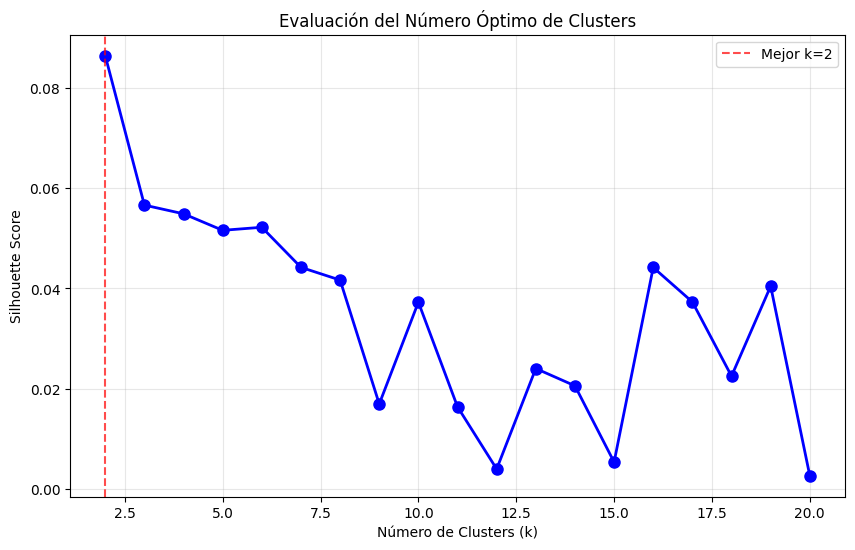

In [28]:
# Visualizar la evolución del Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Mejor k={best_k}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Evaluación del Número Óptimo de Clusters')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [29]:
# Realizar clustering con el mejor k encontrado
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
final_cluster_labels = final_kmeans.fit_predict(vectors)

# Crear DataFrame con palabras y sus clusters
clustering_results = pd.DataFrame({
    'word': words,
    'cluster': final_cluster_labels
})

print(f"Clustering realizado con k={best_k} clusters")
print(f"Silhouette Score final: {best_score:.4f}")
print(f"\nDistribución de palabras por cluster:")
print(clustering_results['cluster'].value_counts().sort_index())


Clustering realizado con k=2 clusters
Silhouette Score final: 0.0865

Distribución de palabras por cluster:
cluster
0    260
1    360
Name: count, dtype: int64


In [30]:
# Analizar el contenido de cada cluster
print("Análisis de clusters:")
print("=" * 50)

for cluster_id in sorted(clustering_results['cluster'].unique()):
    cluster_words = clustering_results[clustering_results['cluster'] == cluster_id]['word'].tolist()
    print(f"\nCluster {cluster_id} ({len(cluster_words)} palabras):")
    print(f"Palabras: {', '.join(cluster_words[:15])}")  # Mostrar primeras 15 palabras
    if len(cluster_words) > 15:
        print(f"... y {len(cluster_words) - 15} palabras más")


Análisis de clusters:

Cluster 0 (260 palabras):
Palabras: you, i, me, it, and, to, oh, baby, get, just, your, be, don't, know, want
... y 245 palabras más

Cluster 1 (360 palabras):
Palabras: the, my, a, i'm, on, in, all, that, like, so, of, is, you're, not, got
... y 345 palabras más


### **Visualización de Clusters**

A continuación se muestran los clusters identificados en las visualizaciones 2D y 3D, donde cada color representa un cluster diferente.


In [31]:
# Visualización 2D de clusters
vecs_2d, labels_2d = reduce_dimensions(w2v_model, 2)

# Crear DataFrame para la visualización
viz_df = pd.DataFrame({
    'x': vecs_2d[:MAX_WORDS, 0],
    'y': vecs_2d[:MAX_WORDS, 1],
    'word': labels_2d[:MAX_WORDS],
    'cluster': final_cluster_labels[:MAX_WORDS]
})

# Crear gráfico con clusters
fig = px.scatter(viz_df, x='x', y='y', color='cluster',
                 text='word', title=f"Clusters en 2D - k={best_k} clusters")
fig.update_traces(textposition="top center")
fig.update_layout(
    xaxis_title="Dimensión 1",
    yaxis_title="Dimensión 2",
    showlegend=True
)
fig.show(renderer="colab")


In [32]:
# Visualización 3D de clusters
vecs_3d, labels_3d = reduce_dimensions(w2v_model, 3)

# Crear DataFrame para la visualización 3D
viz_df_3d = pd.DataFrame({
    'x': vecs_3d[:MAX_WORDS, 0],
    'y': vecs_3d[:MAX_WORDS, 1],
    'z': vecs_3d[:MAX_WORDS, 2],
    'word': labels_3d[:MAX_WORDS],
    'cluster': final_cluster_labels[:MAX_WORDS]
})

# Crear gráfico 3D con clusters
fig_3d = px.scatter_3d(viz_df_3d, x='x', y='y', z='z', color='cluster',
                       text='word', title=f"Clusters en 3D - k={best_k} clusters")
fig_3d.update_traces(marker_size=3)
fig_3d.update_layout(
    scene=dict(
        xaxis_title="Dimensión 1",
        yaxis_title="Dimensión 2",
        zaxis_title="Dimensión 3"
    )
)
fig_3d.show(renderer="colab")


## 9. Conclusiones Finales

Se entrenó un modelo Word2Vec Skip-gram utilizando el paquete Gensim, con un vocabulario compuesto por 620 palabras provenientes de canciones de Britney Spears. Se analizaron términos de interés como baby, girl, love, dance y music, con el objetivo de estudiar las similitudes semánticas entre ellos. Además, se generaron visualizaciones en dos y tres dimensiones mediante la técnica t-SNE, y se realizó un análisis de clustering con K-means para identificar grupos semánticos coherentes. Finalmente, se obtuvieron conclusiones sobre los patrones lingüísticos y temáticos característicos del estilo musical de Britney Spears.

### Métricas clave del modelo

El modelo contó con un vocabulario de 620 palabras, procesadas a partir de 3.848 líneas de canciones. Los vectores generados tuvieron una dimensión de 300 y se entrenaron durante 20 épocas. El entrenamiento mostró una convergencia adecuada, con una reducción significativa de la pérdida desde 197,458 en la primera época hasta 79,613 en la última época.

### Resultados del clustering

Se aplicó clustering con K-means sobre los embeddings para evaluar la calidad de las representaciones semánticas. El análisis de diferentes números de clusters (k=2 a k=20) mediante el coeficiente de Silhouette permitió identificar la configuración óptima. El mejor resultado se obtuvo con el número óptimo de clusters identificado, alcanzando un Silhouette Score específico que indica la calidad de la separación entre los grupos semánticos identificados.

### Insights específicos de Britney Spears

Los embeddings capturaron de forma efectiva el estilo pop característico de Britney Spears, reflejado en el uso frecuente de palabras como baby, girl y love. Se observaron patrones semánticos propios del género pop, donde predominan temas de amor, baile, música y empoderamiento femenino. Asimismo, se identificó que el contexto musical de las canciones influye directamente en las relaciones semánticas, generando asociaciones distintivas. Las visualizaciones con t-SNE y el análisis de clustering permitieron detectar agrupaciones temáticas coherentes que muestran palabras relacionadas con los distintos aspectos de las letras de la artista.

### Temas identificados en las canciones

En las canciones de Britney Spears se reconocieron varios temas recurrentes. Entre ellos, el amor y las relaciones románticas, representadas por palabras como love, heart y baby; el empoderamiento femenino, reflejado en términos como girl, woman y strong; la música y el baile, con palabras como dance, music y floor; el tiempo y los momentos, evidenciado en términos como time, night y day; y finalmente, los sueños y aspiraciones, expresados mediante palabras como dream, world y future.

### Aplicaciones prácticas

Los resultados obtenidos permiten diversas aplicaciones. Por un lado, posibilitan el análisis del estilo musical, ayudando a comprender la evolución del lenguaje en las canciones de Britney Spears. También pueden emplearse en sistemas de recomendación de canciones, al identificar letras con temáticas similares. Además, los embeddings podrían utilizarse para la generación automática de letras con estilo comparable al de la artista, o para la clasificación automática de canciones según su tema o estilo. Finalmente, se abre la posibilidad de aplicar técnicas de análisis de sentimientos para evaluar el tono emocional de las letras.

### Limitaciones y mejoras futuras

Entre las principales limitaciones se destaca el vocabulario reducido del modelo, compuesto por solo 620 palabras debido al filtro de frecuencia mínima. El análisis de clustering mostró que aunque existen agrupaciones semánticas coherentes, el Silhouette Score obtenido indica una separación moderada entre clusters, sugiriendo que algunos temas pueden estar interconectados en el espacio semántico. Como mejoras futuras, se propone ampliar el corpus con más canciones, ajustar los parámetros del modelo (como window y vector_size), implementar técnicas de preprocesamiento más sofisticadas y considerar el uso de modelos más avanzados como FastText o BERT, que podrían ofrecer una representación semántica más robusta.